# Importar 

Importamos lo que necesitamos.

In [1]:
import numpy as np
from qiskit import *

# Diseñamos circuito

Un paso importante es el diseño del circuito. 

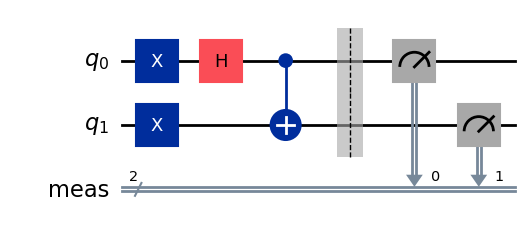

In [2]:
singlet = QuantumCircuit(2)
singlet.x(0)
singlet.x(1)
singlet.h(0)
singlet.cx(0, 1)
singlet.measure_all()
singlet.draw('mpl')

El estado generado es el singlete:

##$$|\psi\rangle=\frac{1}{\sqrt{2}}(|01\rangle - |10\rangle)$$



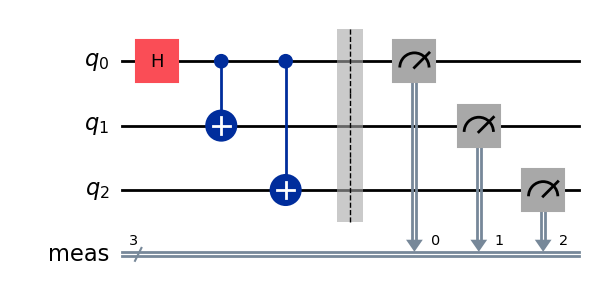

In [3]:
GHZ = QuantumCircuit(3)
GHZ.h(0)
GHZ.cx(0, 1)
GHZ.cx(0, 2)
GHZ.measure_all()
GHZ.draw('mpl')


El estado generado es el GHZ:

$$|\psi\rangle=\frac{1}{\sqrt{2}}(|000\rangle + |111\rangle)$$

El orden es importante. Qiskit numera las cosas al revés. Si el primer qubit está en 0, el segundo en 0 y el tercero en 1, esto se representa en Qiskit como $|100\rangle$. Sin embargo, en los libros, sería usualmente $|001\rangle$. Esto hace que algunas compuertas queden raras (pero no debería llevar a confusión; es cuestión de costumbre).

# Corremos el circuito en un simulador

Para simular los circuitos diseñados, tenemos que elegir un simulador. Qiskit Aer tiene varios "backends" para simular. Hay que elegir alguno.

In [4]:
# Importamos Aer

from qiskit_aer import AerSimulator

backend = AerSimulator()

Ahora que establecimos el backend, hay que ejecutar el circuito. 

In [5]:
# Definimos un "trabajo".
job = backend.run(GHZ, shots = 10)

Ahora pedimos el "resultado" del "trabajo" que mandamos a correr.

In [6]:
result = job.result()

Extraemos las cuentas del circuito.

{'000': 3, '111': 7}


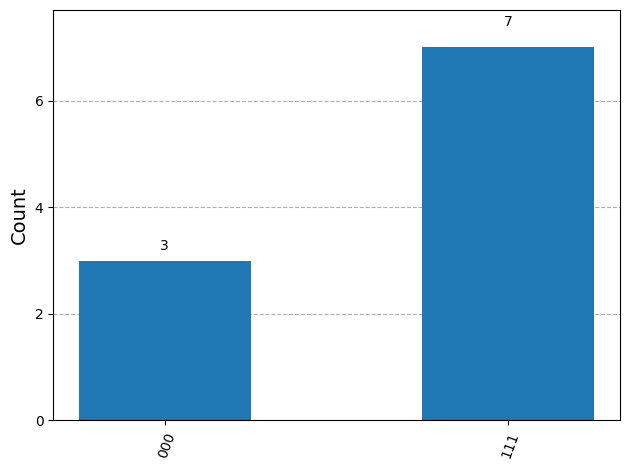

In [7]:
counts = result.get_counts(GHZ)

print(counts)

from qiskit.visualization import plot_histogram

plot_histogram(counts)

# Modelos de ruido

### Modelos de computadoras ya existentes

Con esto se puede correr en distintos simuladores de Qiskit. 
Observar que hay distintos niveles de optimización ("optimization level).

{'111': 3665, '000': 5033, '101': 326, '010': 300, '110': 276, '011': 284, '100': 39, '001': 77}


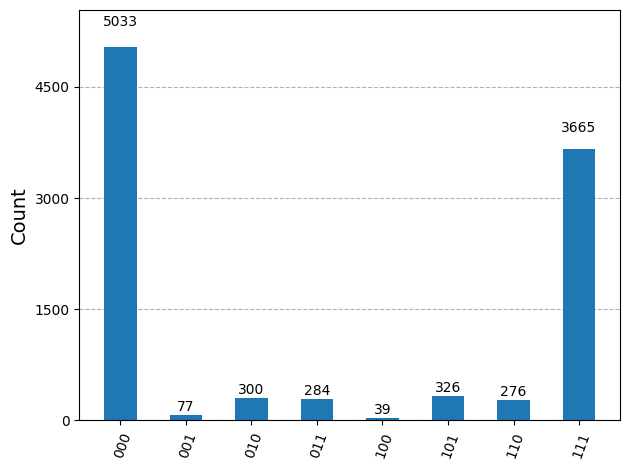

In [12]:
### Correr el circuito en los simuladores que ofrece Qiskit. 
### Comentar y descomentar backends para ir cambiando entre uno y otro.

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeSingaporeV2,FakeMontrealV2,FakeProviderForBackendV2, FakeTorontoV2
 
# Get a fake backend from the fake provider

# backend = FakeManilaV2()

# backend = FakeSingaporeV2()

# backend = sim_noise

# backend = AerSimulator()

# backend = FakeMontrealV2()

backend = FakeTorontoV2()

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

circuit = transpile(GHZ, backend)

target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(GHZ)

circuit_isa.draw()

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

print(dist)
plot_histogram(dist)
#circuit.draw('mpl')


## Modelo de ruido en el que uno modifica los parámetros
Acá mostramos cómo armar un modelo de ruido en el cual podemos ajustar los valores de los parámetros.

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u1', 'u3', 'u2', 'cx', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']
{'110': 30, '001': 45, '101': 51, '010': 36, '000': 363, '100': 37, '011': 54, '111': 384}


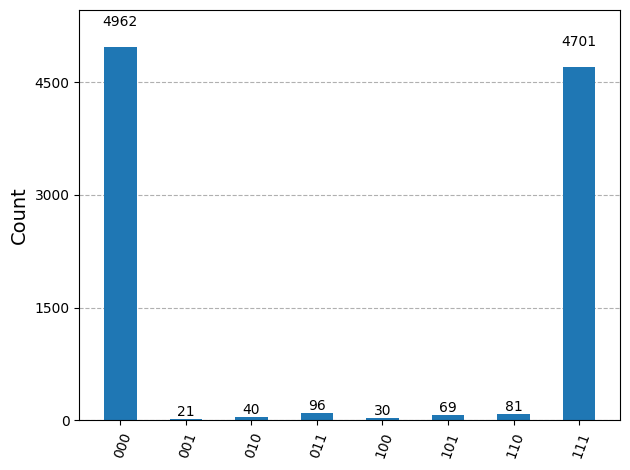

In [25]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Example error probabilities
p_reset = 0.01
p_meas = 0.1
p_gate1 = 0.01
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X", p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

error_depolarizing1 =  depolarizing_error(param = 0.001, num_qubits = 1)
error_depolarizing2 =  depolarizing_error(param = 0.001, num_qubits = 2)
 
# Add errors to noise model
noise = NoiseModel()
noise.add_all_qubit_quantum_error(error_reset, "reset")
noise.add_all_qubit_quantum_error(error_meas, "measure")
# noise.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise.add_all_qubit_quantum_error(error_depolarizing1, ["u1", "u2", "u3"]) 
noise.add_all_qubit_quantum_error(error_depolarizing2, ["cx"]) 

print(noise)

# Create noisy simulator backend

sim_noise = AerSimulator(noise_model=noise)
 
S = 1000

circ = transpile(GHZ, sim_noise)
result = sim_noise.run(circ, shots = S).result()
counts = result.get_counts(circ)

print(counts)

plot_histogram(dist)


In [13]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.
